In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv


# Data

In [2]:
import os
import zipfile
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.optimizers import RMSprop

In [3]:
work_path = './cats_and_dogs_filtered'
os.mkdir(work_path)

In [4]:
local_zip = '../input/dogs-vs-cats/test1.zip'
zip_ref = zipfile.ZipFile(local_zip,'r')
zip_ref.extractall(work_path)

local_zip = '../input/dogs-vs-cats/train.zip'
zip_ref = zipfile.ZipFile(local_zip,'r')
zip_ref.extractall(work_path)

zip_ref.close()

In [5]:
train_path = os.path.join(work_path, 'train')
test_path = os.path.join(work_path, 'test1')

In [6]:
train_df = pd.DataFrame({'image_name':os.listdir(train_path)})
train_df['label'] =train_df['image_name'].apply(lambda x: x.split('.')[0])
train_df

,image_name,label
0,cat.2364.jpg,cat
1,cat.4566.jpg,cat
2,cat.2311.jpg,cat
3,dog.4811.jpg,dog
4,dog.2935.jpg,dog
...,...,...
24995,cat.4039.jpg,cat
24996,cat.5098.jpg,cat
24997,cat.591.jpg,cat
24998,cat.5809.jpg,cat


In [7]:
test_df = pd.DataFrame({'image_name':os.listdir(test_path)})
test_df['label'] =test_df['image_name'].apply(lambda x: x.split('.')[0])
test_df

,image_name,label
0,8791.jpg,8791
1,10695.jpg,10695
2,8333.jpg,8333
3,6525.jpg,6525
4,6482.jpg,6482
...,...,...
12495,6756.jpg,6756
12496,6487.jpg,6487
12497,7640.jpg,7640
12498,2117.jpg,2117


In [8]:
dog_path_train = os.path.join(train_path, 'dog')
os.mkdir(dog_path_train)
dog_df_train = train_df[train_df.label=='dog']
for n in tqdm(dog_df_train.image_name):
    os.rename((os.path.join(train_path, n)), (os.path.join(dog_path_train, n)))

100%|██████████| 12500/12500 [00:00<00:00, 33887.98it/s]


In [9]:
cat_path_train = os.path.join(train_path, 'cat')
os.mkdir(cat_path_train)
cat_df_train = train_df[train_df.label=='cat']
for n in tqdm(cat_df_train.image_name):
    os.rename((os.path.join(train_path, n)), (os.path.join(cat_path_train, n)))

100%|██████████| 12500/12500 [00:00<00:00, 37334.26it/s]


In [10]:
#check

base_dir = './cats_and_dogs_filtered'

print(' Contents of base directory')
print(os.listdir(base_dir))

print('\n Contents of Train directory')
train_path = f'{base_dir}/train'
print(os.listdir(train_path))

print('\n Contents of validation directory')
print(os.listdir(test_path)[:5])

 Contents of base directory
['train', 'test1']

 Contents of Train directory
['dog', 'cat']

 Contents of validation directory
['8791.jpg', '10695.jpg', '8333.jpg', '6525.jpg', '6482.jpg']


In [11]:
train_dir = os.path.join(base_dir,'train')
validation_dir = os.path.join(base_dir,'test1')

train_cats_dir = os.path.join(train_dir,'cat')
train_dogs_dir = os.path.join(train_dir,'dog')

In [12]:
train_cats_names = os.listdir(train_cats_dir)
train_dogs_names = os.listdir(train_dogs_dir)

print(train_cats_names[:5])
print(train_dogs_names[:5])

['cat.2364.jpg', 'cat.4566.jpg', 'cat.2311.jpg', 'cat.3824.jpg', 'cat.5978.jpg']
['dog.4811.jpg', 'dog.2935.jpg', 'dog.2309.jpg', 'dog.1948.jpg', 'dog.2809.jpg']


In [13]:
#number

print(f'numbers of cats in training set = {len(train_cats_names)}')
print(f'numbers of dogs in training set = {len(train_dogs_names)}')
print(f'numbers of cats and dogs in validation set = {len(os.listdir(validation_dir))}')

numbers of cats in training set = 12500
numbers of dogs in training set = 12500
numbers of cats and dogs in validation set = 12500


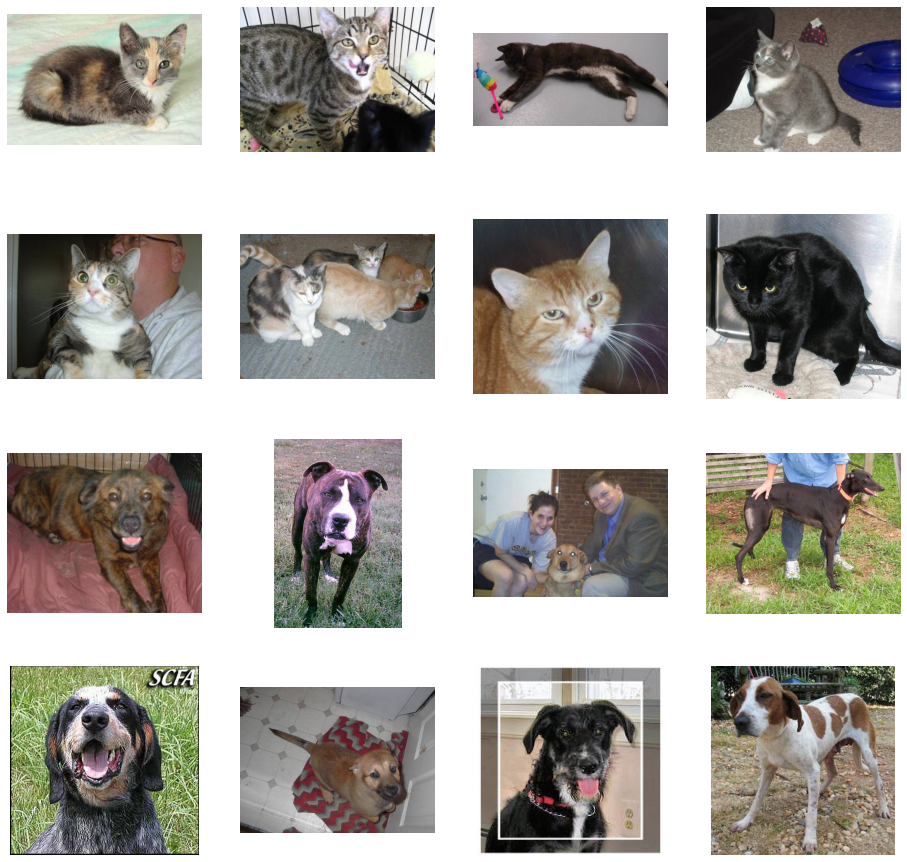

In [14]:
#image 확인

%matplotlib inline

nrows = 4
ncols = 4

pic_index = 0

fig = plt.gcf()
fig.set_size_inches(nrows*4,ncols*4)

next_cat_pic = [os.path.join(train_cats_dir,fname) for fname in train_cats_names[pic_index:pic_index+8]]

next_dog_pic = [os.path.join(train_dogs_dir,fname) for fname in train_dogs_names[pic_index:pic_index+8]]

for i ,img_path in enumerate(next_cat_pic+next_dog_pic):
    sp = plt.subplot(nrows,ncols,i+1)
    sp.axis('off')
    
    img = mpimg.imread(img_path)
    plt.imshow(img)
plt.show() 

# Model

In [15]:
def create_model():

  model = tf.keras.models.Sequential([ 
    tf.keras.layers.Conv2D(16,(3,3), activation = 'relu', input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(32,(3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64,(3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  
  model.compile(optimizer=RMSprop(lr=0.001),
                loss='binary_crossentropy',
                metrics=['accuracy']) 
    
  return model

In [16]:
model = create_model()
model.summary()

2022-05-15 16:25:50.260096: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-15 16:25:50.371942: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-15 16:25:50.372922: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-15 16:25:50.374218: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [17]:
#이미지전처리
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest',
      validation_split=0.2
                                  )

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=50,
    class_mode='binary',
    subset='training'
) 


validation_generator = train_datagen.flow_from_directory(
    train_dir, # same directory as training data
    target_size=(150, 150),
    batch_size=50,
    class_mode='binary',
    subset='validation')

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [18]:
class mycallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if(logs.get('val_accuracy')>=0.90):
            self.model.stop_training = True
            
callback = mycallback()

# Training

In [19]:
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples//50,#batch_size, 
    epochs = 30,
    verbose=1,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples//50,#batch_size,
    callbacks=[callback]
)

2022-05-15 16:25:55.805190: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-05-15 16:25:57.927405: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


400/400 [==============================] - 225s 543ms/step - loss: 0.6823 - accuracy: 0.6075 - val_loss: 0.5825 - val_accuracy: 0.7028
Epoch 2/30
400/400 [==============================] - 216s 539ms/step - loss: 0.5991 - accuracy: 0.6782 - val_loss: 0.5586 - val_accuracy: 0.6972
Epoch 3/30
400/400 [==============================] - 214s 536ms/step - loss: 0.5650 - accuracy: 0.7054 - val_loss: 0.5299 - val_accuracy: 0.7314
Epoch 4/30
400/400 [==============================] - 217s 540ms/step - loss: 0.5403 - accuracy: 0.7287 - val_loss: 0.5360 - val_accuracy: 0.7230
Epoch 5/30
400/400 [==============================] - 217s 542ms/step - loss: 0.5253 - accuracy: 0.7383 - val_loss: 0.4996 - val_accuracy: 0.7584
Epoch 6/30
400/400 [==============================] - 217s 542ms/step - loss: 0.5131 - accuracy: 0.7442 - val_loss: 0.5276 - val_accuracy: 0.7336
Epoch 7/30
400/400 [==============================] - 218s 545ms/step - loss: 0.5009 - accuracy: 0.7580 - val_loss: 0.4924 - val_accura

# Accuracy

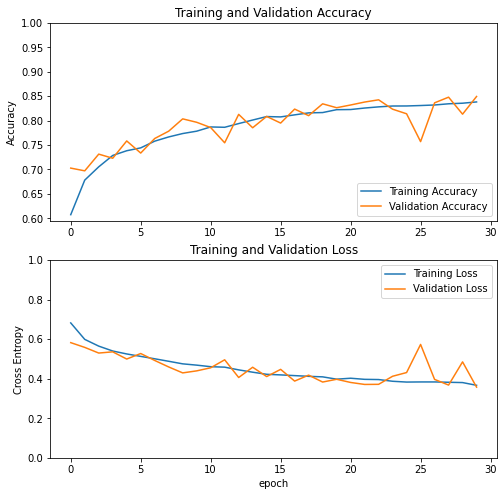

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()